In [1]:
import pickle

import arviz as az
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn.objects as so


T_STEADY_STATE = 5  # years, Assumed time to CD4+ steady state.


def read_obs_hiv_cd4_timeseries():
    """Read the patient cd4 time series spreadsheet."""
    df = pd.read_csv("../data/pantaleo1995-figure1.csv")
    df = df.rename({"cd4_cells_per_mm3": "cd4"}, axis='columns')
    df.year += T_STEADY_STATE
    df["day"] = df.year * 365
    # Convert subject strings to float for PyMC's Distribution class that has a
    # convert_observed_data() function that assumes all data should be float.
    df["group"] = df["group"].str.extract(r"subject(\d+)")
    return df


# Sorting by time is necessary for merging columns later on.
DF_OBSERVED = read_obs_hiv_cd4_timeseries().sort_values("day")
# Collapse data into single representative sample.
DF_OBSERVED_1 = DF_OBSERVED[DF_OBSERVED["group"] == "1"]
OBSERVED = DF_OBSERVED_1.cd4.to_numpy()
# Only solve the ODE system at timepoints for which we have data.  T_VALS is in
# days because all the parameter units are in days.
T_VALS = DF_OBSERVED_1.day.to_numpy()
# Initial values.
Y0 = [1e3, 0, 0, 1e-3]


def hiv(y, t, s, r, T_max, mu_T, mu_b, mu_V, k_1, k_2, N):
    """Rates of change RHS (equations 5a-5d, page 87)."""
    return np.array([
        # T
        s - mu_T*y[0] + r*y[0]*(1 - (y[0] + y[1] + y[2])/T_max) -
        k_1*y[3]*y[0],
        # T_li
        k_1*y[3]*y[0] - mu_T*y[1] - k_2*y[1],
        # T_ai
        k_2*y[1] - mu_b*y[2],
        # V
        N*mu_b*y[2] - k_1*y[3]*y[0] - mu_V*y[3],
    ])


def simulate_hiv(rng, s, r, T_max, mu_T, mu_b, mu_V, k_1, k_2, N, size=None):
    # Pad zero value time to match the Y0 initial condition.
    times = np.concatenate((np.zeros((1,)), T_VALS))
    ret = odeint(hiv, Y0, times, rtol=0.1, mxstep=100,
                 args=(s, r, T_max, mu_T, mu_b, mu_V, k_1, k_2, N))
    # Remove zero value time padding to match data.
    return ret[1:, :]

In [2]:
with open("perelson1993-01_output-idata_hiv.pkl", "rb") as file_:
    idata_hiv = pickle.load(file_)

In [3]:
az.summary(idata_hiv)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
T_max,715.477,90.586,568.000,888.000,2.500,1.808,1376.0,886.0,1.01
N,924.761,248.180,487.000,1409.000,6.106,4.328,1665.0,1694.0,1.01
s,0.346,0.280,0.028,0.815,0.006,0.004,1952.0,1472.0,1.00
r,726.696,352.081,203.136,1355.833,9.366,6.624,1304.0,1311.0,1.01
mu_T,80.200,48.967,11.847,169.950,1.265,0.895,1362.0,1216.0,1.01
mu_b,11.590,10.579,0.835,26.578,0.375,0.350,1603.0,1371.0,1.01
mu_V,1.435,1.203,0.054,3.606,0.037,0.026,1006.0,896.0,1.01
k_1,155846.658,114677.442,15920.121,363677.189,2876.308,2034.230,1498.0,1173.0,1.01
k_2,1183.134,715.702,218.344,2495.619,18.205,13.694,1551.0,797.0,1.01


In [4]:
posterior = idata_hiv.posterior.stack(samples=('draw', 'chain'))
posterior

<xarray.Dataset>
Dimensions:  (samples: 16000)
Coordinates:
  * samples  (samples) object MultiIndex
  * draw     (samples) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999
  * chain    (samples) int64 0 1 2 3 4 5 6 7 0 1 2 3 ... 4 5 6 7 0 1 2 3 4 5 6 7
Data variables:
    T_max    (samples) int64 623 879 689 644 703 784 ... 642 707 843 755 764 770
    N        (samples) int64 1030 726 917 558 804 649 ... 937 1146 720 876 849
    s        (samples) float64 1.076 0.3073 0.1365 ... 0.9671 1.127 0.1959
    r        (samples) float64 370.2 503.9 431.7 488.9 ... 487.9 375.4 1.395e+03
    mu_T     (samples) float64 60.34 73.28 80.77 36.88 ... 102.6 133.9 57.22
    mu_b     (samples) float64 20.09 13.85 4.276 1.488 ... 19.4 1.23 11.91 10.82
    mu_V     (samples) float64 2.589 0.3173 1.671 0.6986 ... 0.672 3.561 0.6243
    k_1      (samples) float64 7.426e+04 8.01e+04 ... 4.775e+04 2.967e+05
    k_2      (samples) float64 1.396e+03 535.4 1.197e+03 ... 1.739e+03 653.3
Attributes:
    created_at:                 2023-06-21T00:16:13.225876
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

array([[<Axes: title={'center': 'T_max'}>, <Axes: title={'center': 'N'}>,
        <Axes: title={'center': 's'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'mu_T'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'mu_V'}>,
        <Axes: title={'center': 'k_1'}>, <Axes: title={'center': 'k_2'}>]],
      dtype=object)

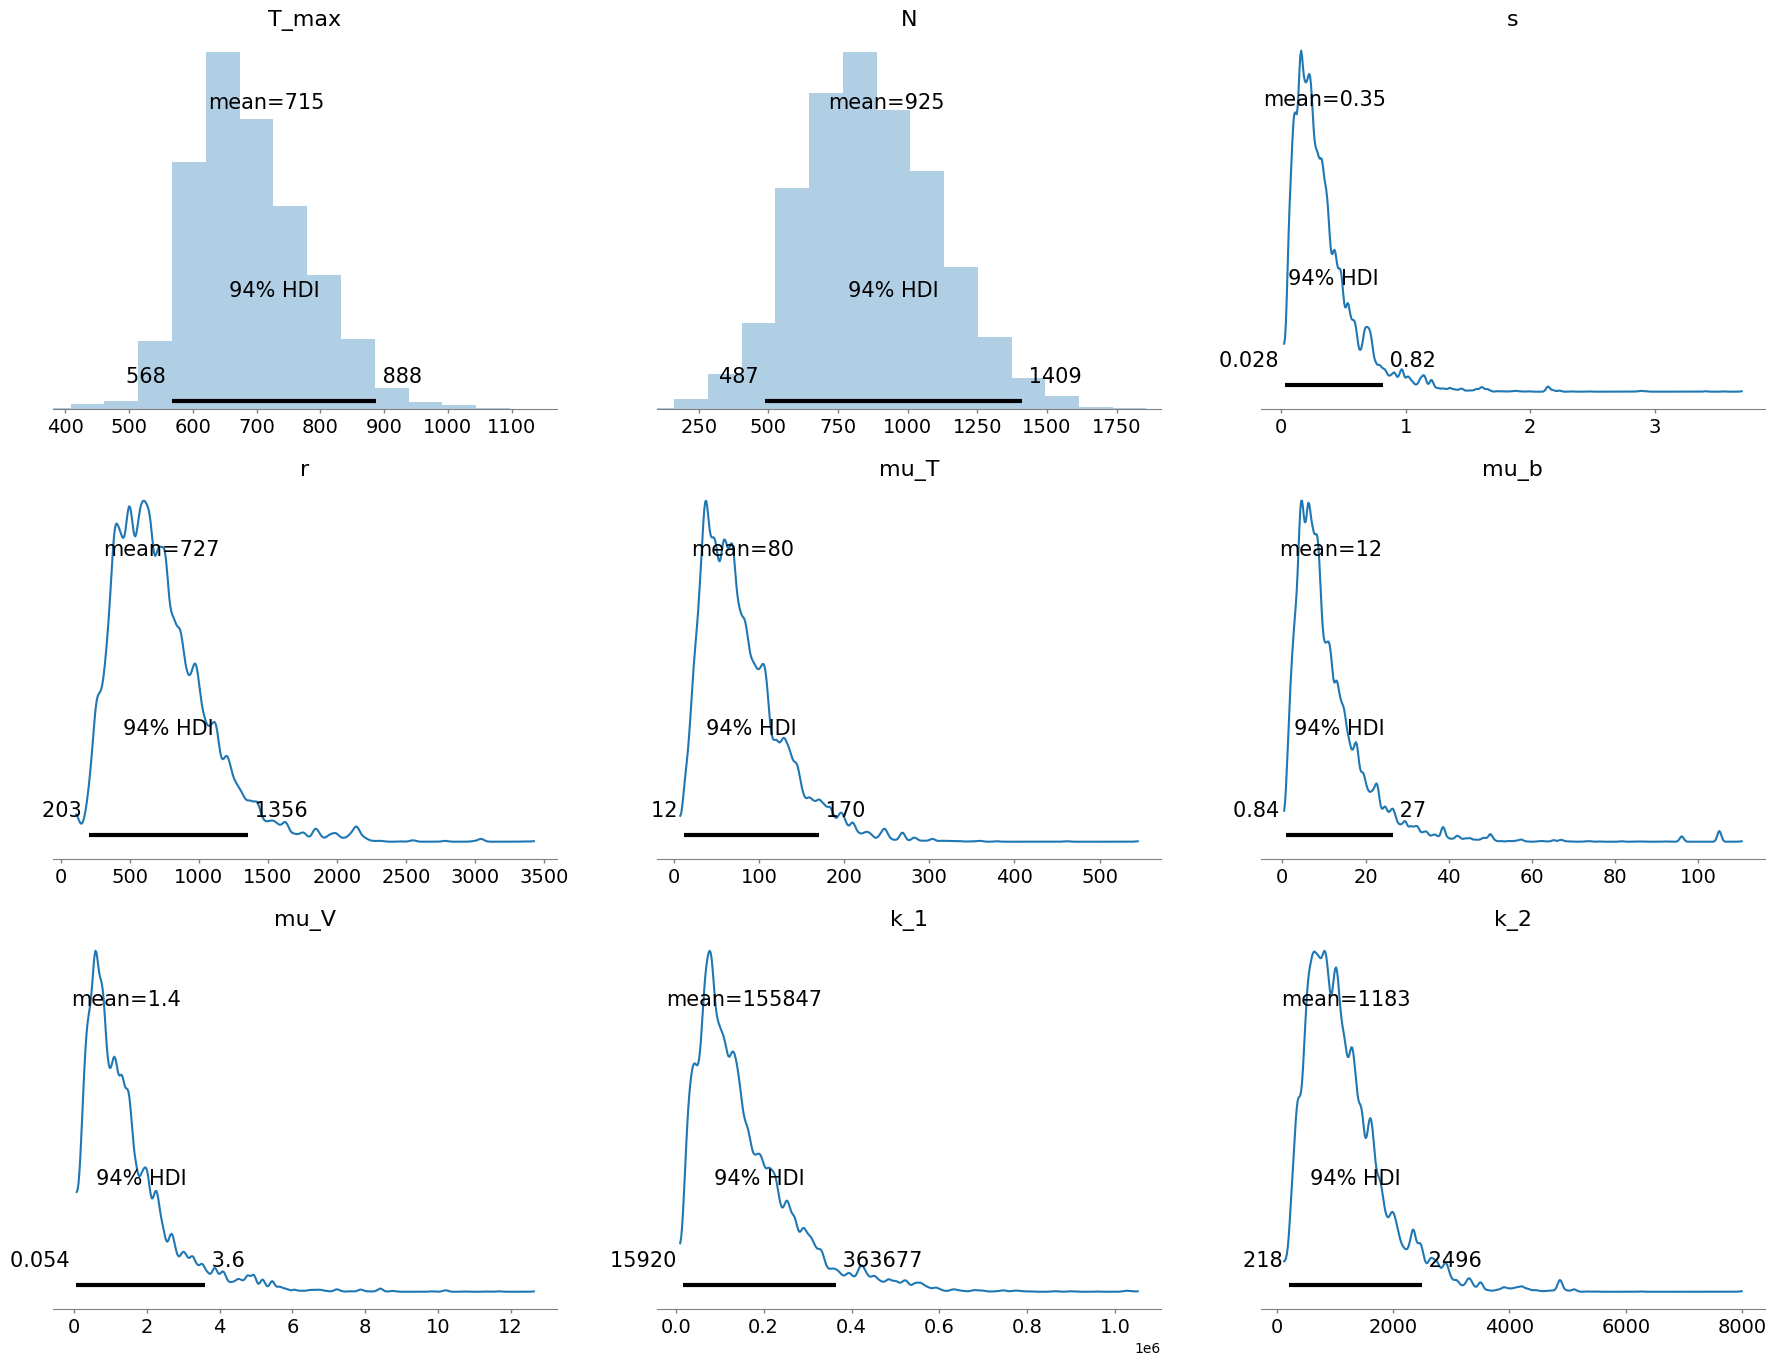

In [5]:
az.plot_posterior(idata_hiv)

array([[<Axes: ylabel='N'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='s'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='r'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_T'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_b'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_V'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='k_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='T_max', ylabel='k_2'>, <Axes: xlabel='N'>,
        <Axes: xlabel='s'>, <Axes: xlabel='r'>, <Axes: xlabel='mu_T'>,
        <Axes: xlabel='mu_b'>, <Axes: xlabel='mu_V'>,
        <Axes: xlabel='k_1'>]], dtype=object)

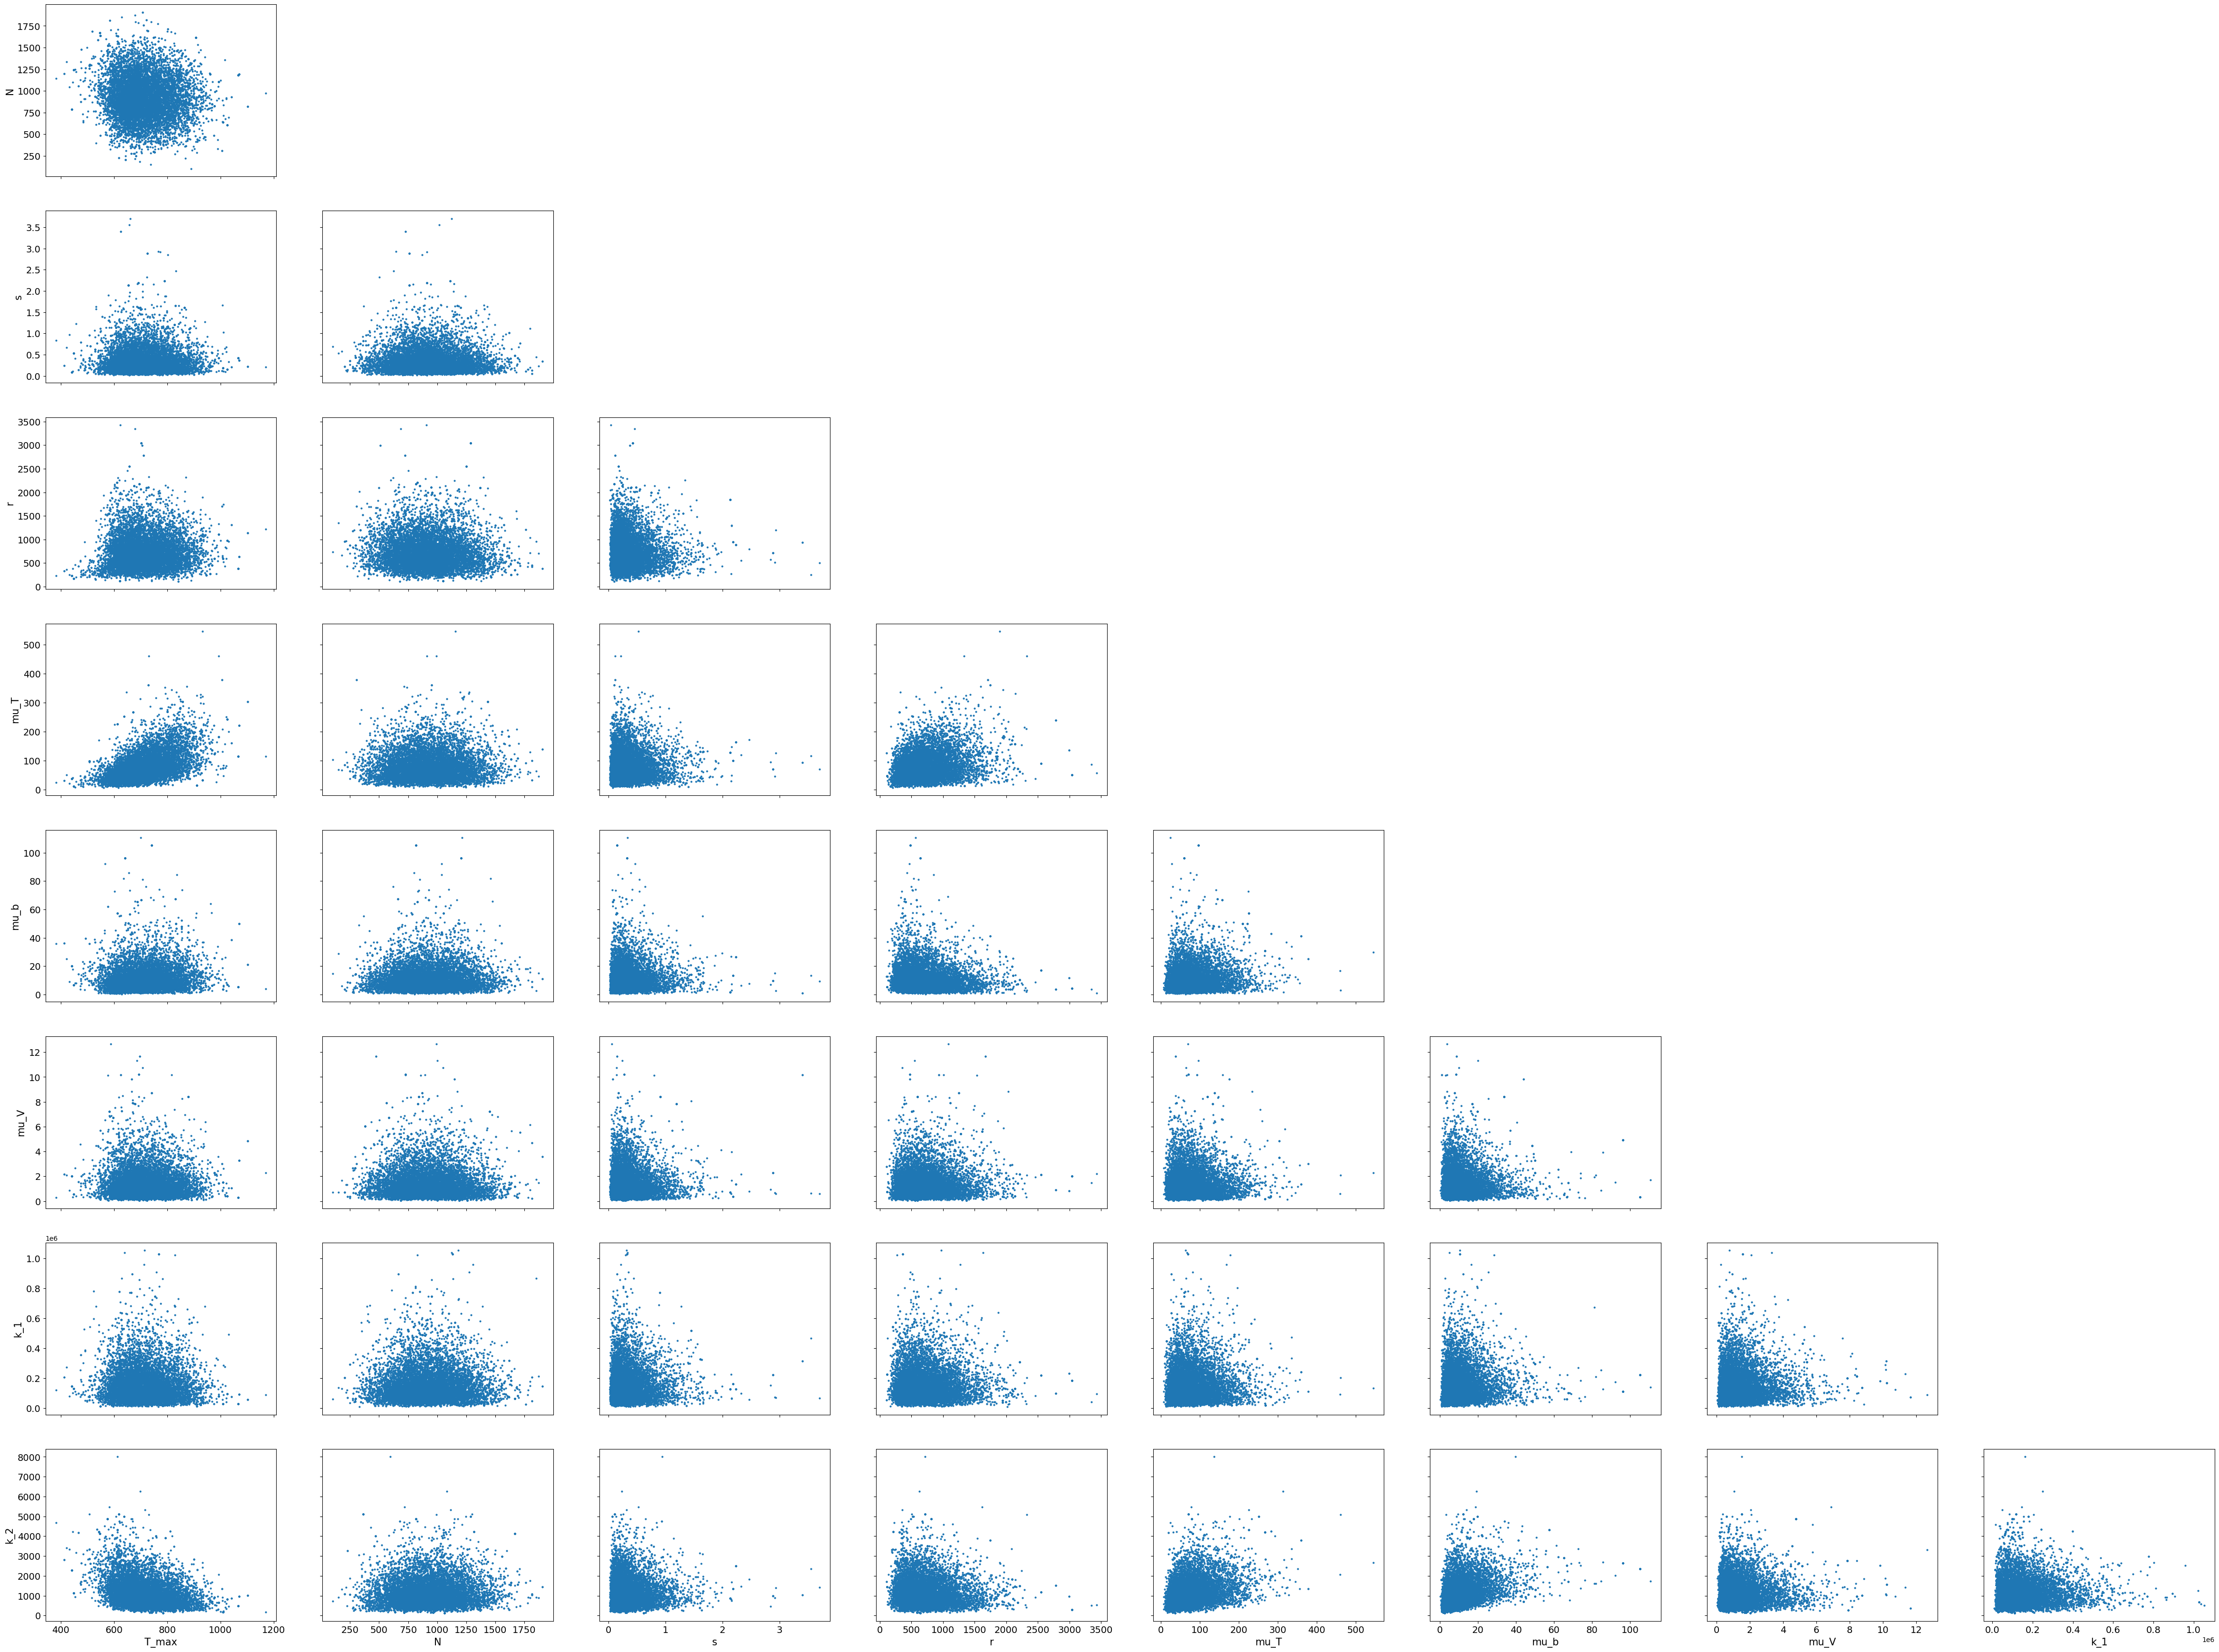

In [ ]:
az.plot_pair(idata_hiv)

In [7]:
obs_var = [key for key in idata_hiv.observed_data.variables.keys()][-1]
obs_cd4 = idata_hiv.observed_data[obs_var]
obs_cd4

<xarray.DataArray 'sim' (sim_dim_0: 18)>
array([ 540.,  660.,  820.,  660.,  780.,  980.,  620.,  940.,  940.,
        700.,  580.,  940.,  980., 1060., 1020.,  820.,  940.,  820.])
Coordinates:
  * sim_dim_0  (sim_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

In [8]:
params = [key for key in idata_hiv.posterior.keys()]
params

['T_max', 'N', 's', 'r', 'mu_T', 'mu_b', 'mu_V', 'k_1', 'k_2']

In [9]:
num_samples=100
samples = az.extract(idata_hiv, num_samples=num_samples)
samples

<xarray.Dataset>
Dimensions:  (sample: 100)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 4 4 3 5 2 1 2 1 0 1 2 4 ... 7 7 6 1 7 6 5 6 1 5 6 2
  * draw     (sample) int64 1875 753 229 571 157 160 ... 1398 163 1835 722 1212
Data variables:
    T_max    (sample) int64 667 852 601 655 642 794 ... 715 969 868 779 752 686
    N        (sample) int64 993 1028 1152 1183 1146 972 ... 845 1150 522 825 784
    s        (sample) float64 0.5789 0.3738 0.3743 ... 0.08544 0.3958 0.2982
    r        (sample) float64 1.001e+03 617.9 841.0 ... 957.8 1.115e+03 903.6
    mu_T     (sample) float64 68.59 162.8 43.94 41.75 ... 20.58 151.1 33.72
    mu_b     (sample) float64 6.623 2.028 12.25 50.28 ... 5.629 13.2 8.213 31.11
    mu_V     (sample) float64 0.8901 1.514 1.236 0.2155 ... 4.592 1.086 1.745
    k_1      (sample) float64 3.919e+04 1.812e+05 ... 7.053e+04 4.56e+04
    k_2      (sample) float64 1.314e+03 931.6 2.477e+03 ... 2.915e+03 1.435e+03
Attributes:
    created_at:                 2023-06-21T00:16:13.225876
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

In [10]:
df = samples.to_dataframe()
df.drop(columns=df.columns[[-2, -1]], inplace=True)
df["cd4"] = df.apply(lambda x: np.sum(simulate_hiv(None, *x)[:, 0:3], axis=1), axis=1)
df = df.explode("cd4")
df["cd4"] = pd.to_numeric(df["cd4"])
df["day"] = np.tile(T_VALS, num_samples)
# seaborn's object interface can't use the intersection of 2 groups yet.
df["sample"] = df.groupby(["chain", "draw"]).ngroup()
# seaborn plotting runs extremely slowly if multi-indexing is active.
df = df.reset_index()
df

/Users/pnanda/Library/Python/3.11/lib/python/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


,chain,draw,T_max,N,s,r,mu_T,mu_b,mu_V,k_1,k_2,cd4,day,sample
0,4,1875,667,993,0.578879,1001.490361,68.593011,6.622866,0.890073,39190.189486,1313.637127,8.198374,2007.5,62
1,4,1875,667,993,0.578879,1001.490361,68.593011,6.622866,0.890073,39190.189486,1313.637127,0.000000,2190.0,62
2,4,1875,667,993,0.578879,1001.490361,68.593011,6.622866,0.890073,39190.189486,1313.637127,0.000000,2372.5,62
3,4,1875,667,993,0.578879,1001.490361,68.593011,6.622866,0.890073,39190.189486,1313.637127,0.000000,2555.0,62
4,4,1875,667,993,0.578879,1001.490361,68.593011,6.622866,0.890073,39190.189486,1313.637127,0.000000,2737.5,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2,1212,686,784,0.298231,903.579198,33.715467,31.110892,1.744595,45597.411740,1435.243920,1.363121,4380.0,35
1796,2,1212,686,784,0.298231,903.579198,33.715467,31.110892,1.744595,45597.411740,1435.243920,1.363121,4562.5,35
1797,2,1212,686,784,0.298231,903.579198,33.715467,31.110892,1.744595,45597.411740,1435.243920,1.363121,4745.0,35
1798,2,1212,686,784,0.298231,903.579198,33.715467,31.110892,1.744595,45597.411740,1435.243920,1.363121,5110.0,35


In [11]:
df.describe()

,chain,draw,T_max,N,s,r,mu_T,mu_b,mu_V,k_1,k_2,cd4,day,sample
count,1800.000000,1800.000000,1800.00000,1800.00000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,3.380000,923.350000,717.24000,914.69000,0.372315,755.605536,84.792470,10.979936,1.298348,140429.911659,1182.009620,3.342407,3583.083333,49.500000
std,2.253535,570.321884,80.04425,254.53339,0.276902,327.639114,50.674073,8.197530,0.982268,98255.353481,738.010857,2.021157,979.537648,28.874092
min,0.000000,0.000000,575.00000,102.00000,0.066433,118.811190,11.899582,0.961786,0.053687,15981.670555,267.496000,0.000000,2007.500000,0.000000
25%,1.000000,405.750000,659.50000,746.00000,0.181815,500.801140,44.546220,5.370538,0.522728,76546.054747,696.502523,2.070694,2737.500000,24.750000
50%,3.000000,819.000000,701.00000,950.50000,0.299074,691.084596,73.559470,8.800039,1.083913,115649.659984,1010.607979,2.893629,3595.250000,49.500000
75%,5.000000,1403.500000,763.75000,1095.00000,0.451801,966.220280,112.808154,14.905590,1.761203,184717.115609,1443.769532,4.910419,4380.000000,74.250000
max,7.000000,1983.000000,969.00000,1816.00000,1.336629,1820.431174,282.146638,50.278005,4.769399,577344.611075,4874.800918,15.908247,5292.500000,99.000000


In [12]:
# Encapsulate observed data and row-bind it to the simulations for plotting.
df_data = pd.DataFrame({"cd4": obs_cd4, "day": T_VALS, "sample": num_samples, "type": "observed"})
df_data

,cd4,day,sample,type
0,540.0,2007.5,100,observed
1,660.0,2190.0,100,observed
2,820.0,2372.5,100,observed
3,660.0,2555.0,100,observed
4,780.0,2737.5,100,observed
5,980.0,2920.0,100,observed
6,620.0,3102.5,100,observed
7,940.0,3285.0,100,observed
8,940.0,3504.0,100,observed
9,700.0,3686.5,100,observed


In [13]:
df["type"] = "simulated"
df_both = pd.concat([df_data, df]).reset_index()
df_both

,index,cd4,day,sample,type,chain,draw,T_max,N,s,r,mu_T,mu_b,mu_V,k_1,k_2
0,0,540.000000,2007.5,100,observed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,660.000000,2190.0,100,observed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,820.000000,2372.5,100,observed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,660.000000,2555.0,100,observed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,780.000000,2737.5,100,observed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,1795,1.363121,4380.0,35,simulated,2.0,1212.0,686.0,784.0,0.298231,903.579198,33.715467,31.110892,1.744595,45597.41174,1435.24392
1814,1796,1.363121,4562.5,35,simulated,2.0,1212.0,686.0,784.0,0.298231,903.579198,33.715467,31.110892,1.744595,45597.41174,1435.24392
1815,1797,1.363121,4745.0,35,simulated,2.0,1212.0,686.0,784.0,0.298231,903.579198,33.715467,31.110892,1.744595,45597.41174,1435.24392
1816,1798,1.363121,5110.0,35,simulated,2.0,1212.0,686.0,784.0,0.298231,903.579198,33.715467,31.110892,1.744595,45597.41174,1435.24392


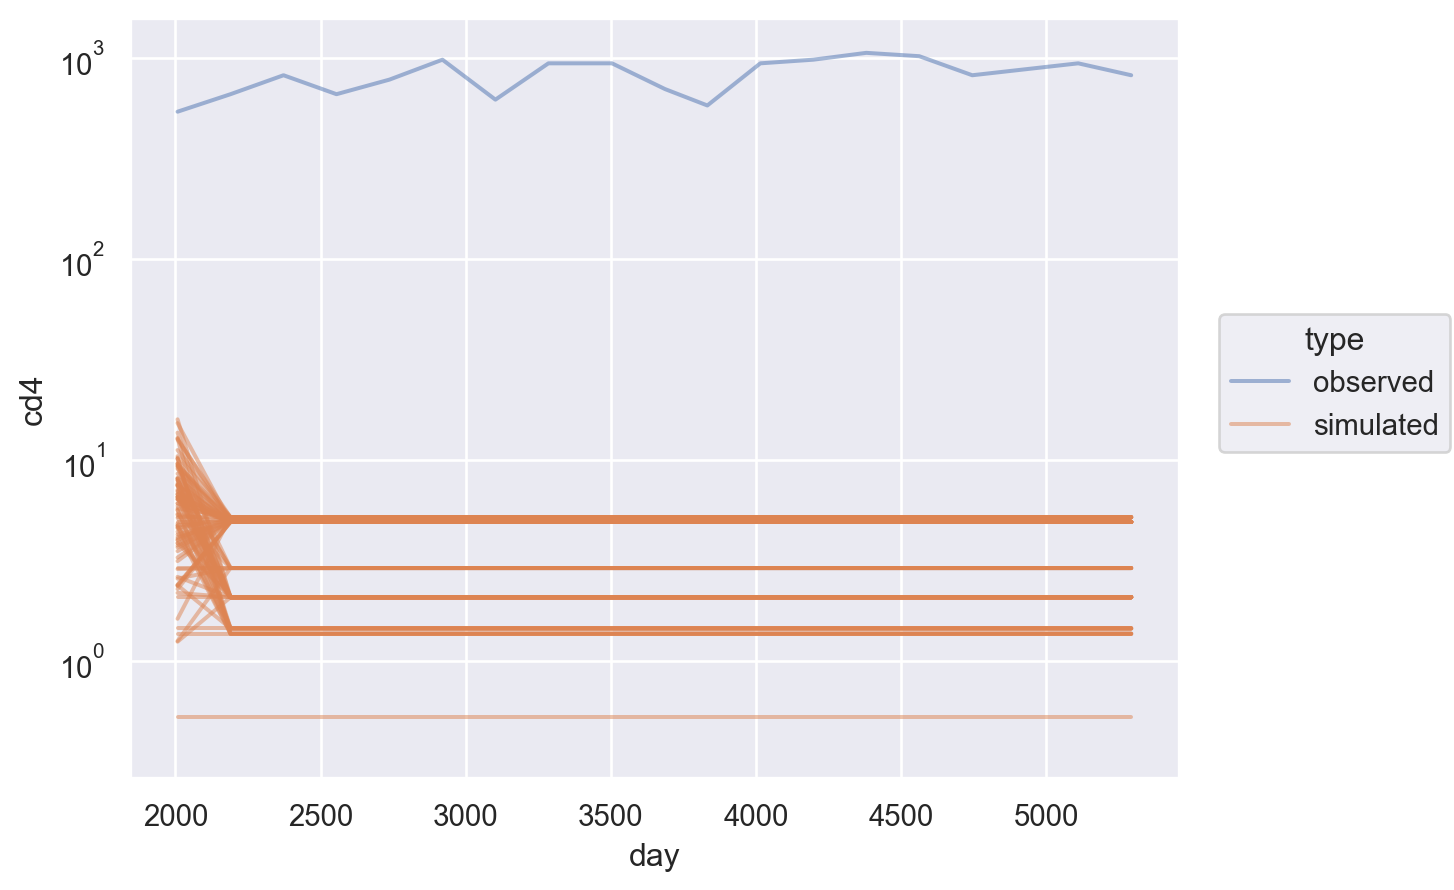

In [14]:
(
    so.Plot(df_both, x="day", y="cd4", group="sample", color = "type")
    .add(so.Line(alpha = .5))
    .scale(y="log")
)